## Introducing the Community Earth System Model (CESM)
This notebook is adapted from [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

## About the CESM

### Overview

The CESM is one example of complex coupled GCMS utilized by the Intergovernmental Panel for Climate Change report process.  It is developed and maintained at NCAR by a group of software engineers and climate processes.  The code is open-source, with new pieces contributed by a wide variety of users.

### Key Componenets

The CESM is a modular piece of software, meaning that a researcher can use which submodels to combine together to best answer their invididual research question with the computer power they have available.

Pieces of the CSEM include:
- Atmospheric model (AGCM): Community Atmosphere Model (CAM)
    -- This model maintains a resolution of approximately 2º lat/long, meaning that while it resolves synoptic-scale dynamics like storm tracks and cyclones, it is not capable of resolving mesoscale and smaller events like thunderstorms or clouds.  The model conserves momentum, mass, energy, water, and the equation of state, while parameterizing weather phenomena and solving equations of radiative transfer based on the composition of the atmosphere, absorption properties of different gases, and the radiative effects of clouds
- Ocean model (OGCM): Parallel Ocean Program (POP)
    -- This model has a 1º lat/long resolution and models the exchanges of heat, water, and momentum in the atmosphere and sea ice.  It includes a full 3D simulation of the currents.
- Land surface model: Community Land Model (CLM)
    -- Like the atmospheric model, this model maintains a 2º lat/long resolution.  It's complex, but, in short, determined the surface fluxes of heat, water, and momentum based on vegetation types.
- Sea ice model: Community Ice CodE (CICE)
    -- This model has a 1º lat/long resolution.  It is incredibly complex and uses thermodynamics to determine freezing and melting and momentum equations to track ice motion and deformation.

### Setting up the model
In order to run the model, we need to give it realistic atmospheric compositions, solar radiations, et cetera.  We will first perform a control - a preindustrial run - and get the average of several years, then do our test run - with double the original atmospheric CO2 - and run it several times to allow the model to adjust to the new equilibrium.

All of our data is stored in `NetCDF` files, which contain self-describing gridded data 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

### Boundary conditions: continents and topography

To begin setting up our models, we are first going to input the topography file.  This file was retrieved from the [class Slack page](https://app.slack.com/client/T01JVA6NV46/C01JVA6PJCE) and saved to each of our computers, meaning that the user of this lab write-up will need to update the below file path to retrieve the file.

In [2]:
#  Open the topography dataset
#  Remember to update file path to the location of your file
topo = xr.open_dataset( "/Users/Andrea/Downloads/USGS-gtopo30_1.9x2.5_remap_c050602.nc" )
print(topo)

# access individual variables within the 'xarray.Dataset'
topo.PHIS

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144)
Coordinates:
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    PHIS          (lat, lon) float64 ...
    SGH           (lat, lon) float64 ...
    SGH30         (lat, lon) float64 ...
    LANDFRAC      (lat, lon) float64 ...
    LANDM_COSLAT  (lat, lon) float64 ...
Attributes:
    history:    Written on date: 20050602\ndefinesurf -remap -t /fs/cgd/csm/i...
    make_ross:  true
    topofile:   /fs/cgd/csm/inputdata/atm/cam/topo/USGS-gtopo30_10min_c050419.nc
    gridfile:   /fs/cgd/csm/inputdata/atm/cam/coords/fv_1.9x2.5.nc
    landmask:   /fs/cgd/csm/inputdata/atm/cam2/hrtopo/landm_coslat.nc


<xarray.DataArray 'PHIS' (lat: 96, lon: 144)>
array([[2.796465e+04, 2.796465e+04, 2.796465e+04, ..., 2.796465e+04,
        2.796465e+04, 2.796465e+04],
       [2.718626e+04, 2.724515e+04, 2.730367e+04, ..., 2.699761e+04,
        2.706319e+04, 2.712589e+04],
       [2.562017e+04, 2.579349e+04, 2.595301e+04, ..., 2.497548e+04,
        2.521368e+04, 2.542803e+04],
       ...,
       [1.720216e-02, 7.134989e-03, 2.748055e-03, ..., 1.569097e-01,
        8.055879e-02, 3.857289e-02],
       [5.444020e-02, 3.951677e-02, 2.799566e-02, ..., 1.231596e-01,
        9.609957e-02, 7.320690e-02],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    long_name:   surface geopotential
    units:       m2/s2
    from_hires:  true
    filter:      remap

### Plotting the topography
After investigating the topography dataset, we are ready to plot the topography of the Earth's surface on this 2º lat/long grid based on the geopotential variable.  

The below code makes a colorful topographic plot, with a land-scea mask so that nothing is plotted on ocean-covered plot points.  

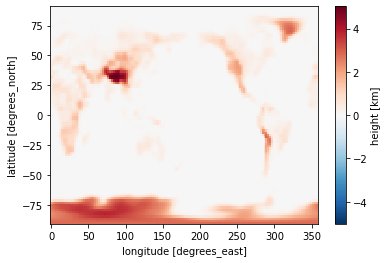

In [3]:
g = 9.8  # gravity in m/s2
meters_per_kilometer = 1E3 # define that there are 1000 meters per kilometer
height = topo.PHIS / g / meters_per_kilometer  # convert the topography from meters to kilometers
#  Note that we have just created a new xarray.DataArray object that preserves the axis labels
#  Let's go ahead and give it some useful metadata:
height.attrs['units'] = 'km'
height.name = 'height'
height # open xarray.Dataarray height variable
height.plot() # produce topography plot

To produce a more attractive plot, we can use matplotlib.

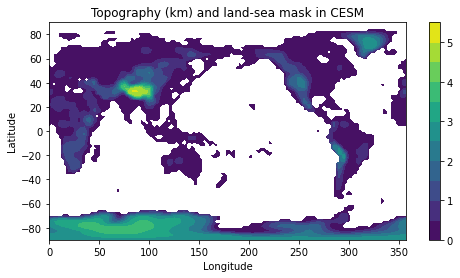

In [4]:
#  A filled contour plot of topography with contours every 500 m
lev = np.arange(0., 6., 0.5)
fig1, ax1 = plt.subplots(figsize=(8,4))
# Here we are masking the data to exclude points where the land fraction is zero (water only)
cax1 = ax1.contourf( height.lon, height.lat, 
                    height.where(topo.LANDFRAC>0), levels=lev)
ax1.set_title('Topography (km) and land-sea mask in CESM')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
cbar1 = fig1.colorbar(cax1)

The 2º of our topography plots means that while we can see certain smaller features like Pacific island, these are lumped together into larger plots with fractional land covery for each grid point.

In order to see areas with only "some" water, we can plot the land-sea mask itself.  Areas with 0.0 ocean mask are completely water (like the middle of an ocean) while areas with 1.0 ocean mask are dry land, like the middle of a contient.  Notice that major likes, like Lake Victoria or Lake Eerie, are not visible on this map.

<ipython-input-5-2f31e660cd5f>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cax2 = ax2.pcolormesh( topo.lon, topo.lat, topo.LANDFRAC ) #plot longitude on the x-axis, latitude on the y-axis, and a colorscale


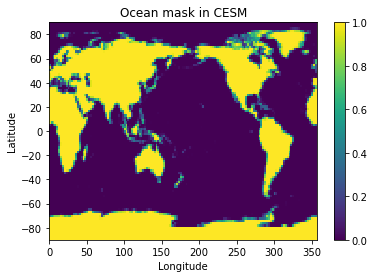

In [5]:
fig2, ax2 = plt.subplots() # produce a second figure
cax2 = ax2.pcolormesh( topo.lon, topo.lat, topo.LANDFRAC ) #plot longitude on the x-axis, latitude on the y-axis, and a colorscale
ax2.set_title('Ocean mask in CESM') # title 
ax2.set_xlabel('Longitude'); ax2.set_ylabel('Latitude') # x and y axis labels
cbar2 = fig2.colorbar(cax2); # color key

However, notice that the latitude-longitude array, as plotted above, does not have a map projection and is therefore highly distorted.

### Ocean Boundary Conditions

Next, we will visualize the ocean and its interaction with the atmosphere.  Remember that the ocean and sea ice models use a different grid (1º lat/long) than the atmosphere grid (2º lat/long).

First, we will open another dataset.  As before, this dataset is from the class Slack page, and the reader of this notebook should take care to replace the file path with the one for their computer.

In [6]:
som_input = xr.open_dataset("/Users/Andrea/Downloads/pop_frc.1x1d.090130.nc")
print(som_input)

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 12)
Coordinates:
  * time     (time) object 0001-01-15 00:00:00 ... 0001-12-16 00:00:00
Dimensions without coordinates: lat, lon
Data variables:
    area     (lat, lon) float64 ...
    mask     (lat, lon) int32 ...
    yc       (lat) float32 ...
    xc       (lon) float32 ...
    S        (time, lat, lon) float32 ...
    T        (time, lat, lon) float32 ...
    U        (time, lat, lon) float32 ...
    V        (time, lat, lon) float32 ...
    dhdx     (time, lat, lon) float32 ...
    dhdy     (time, lat, lon) float32 ...
    hblt     (time, lat, lon) float32 ...
    qdp      (time, lat, lon) float32 ...
Attributes:
    creation_date:  Fri Jan 30 10:22:53 MST 2009
    comment:        This data is on a standard 1x1d grid.
    calendar:       standard
    author:         D. Bailey
    note3:          qdp is computed from depth summed ocean column
    note2:          all fields interpolated to T-grid
    note1:          fields comp

After inputting the dataset, we determined the mean heat flux out of the ocean.  This information is stored in the 'qdp' field of the above dataset.  By convention, if qdp is greater than zero, heat is going into the ocean; if qdp is less than zero, heat is coming out of the ocean.  We changed the sign in order to plot heat heading out of the ocean and into the atmosphere. 

The data is in the units of Wm-2 and there are 12 x 180 x 360 data points, meaning one 180 x 360 grid for each calendar month.

With this information, we can calculate the average annual heat flux out of the ocean over the year at every grid cell.  

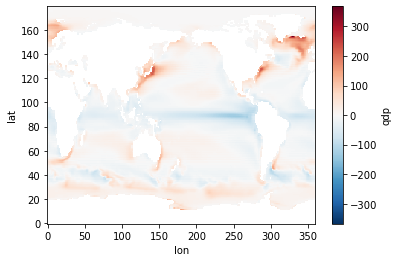

In [7]:
som_input.qdp # look over the data
(-som_input.qdp.mean(dim='time')).plot() # calculate and graph the mean year-round heat flux out of the ocean

We can then pretty up this graph by adding outlines to the continents, a discrete color scale, and fixing up the labels. 

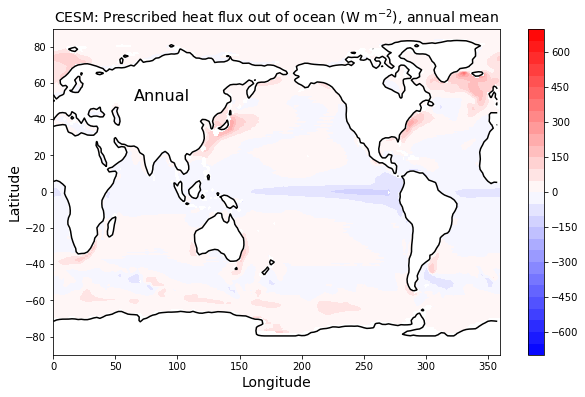

In [8]:
#  We can always set a non-standard size for our figure window
fig3, ax3 = plt.subplots(figsize=(10, 6))
lev = np.arange(-700., 750., 50.)
cax3 = ax3.contourf(som_input.xc, som_input.yc, 
                    -som_input.qdp.mean(dim='time'), 
                    levels=lev, cmap=plt.cm.bwr)
cbar3 = fig3.colorbar(cax3)
ax3.set_title( 'CESM: Prescribed heat flux out of ocean (W m$^{-2}$), annual mean', 
              fontsize=14 )
ax3.set_xlabel('Longitude', fontsize=14)
ax3.set_ylabel('Latitude', fontsize=14)
ax3.text(65, 50, 'Annual', fontsize=16 )
ax3.contour(topo.lon, topo.lat, topo.LANDFRAC, levels=[0.5], colors='k');

From this graph, we noticed that most of the incoming heat (blue) was at the equator, especially in the Pacific.  Areas with outgoing heat (red), meanwhile, where around the mid-Atlantic coats around Asia, North America, and the northernmost parts of the Atlantic.

This structure is a result of ocean currents, though we didn't model the ocean currents directly here, but rather described the heat flux patterns as an input to the atmosphere without explaining their underlying structure.

Next, we looked at the data from just one month

In [9]:
# select by month index (0 through 11)
som_input.qdp.isel(time=0)

#  select by array slicing (but for this you have to know the axis order!)
# by specifying [0,:,:] after the variable name, we selected just January.
som_input.qdp[0,:,:]

<xarray.DataArray 'qdp' (lat: 180, lon: 360)>
array([[      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       ...,
       [-5.75126 , -5.742314, -5.734764, ..., -5.792866, -5.774798, -5.761612],
       [-5.533446, -5.537023, -5.540624, ..., -5.522859, -5.526363, -5.529893],
       [-5.31631 , -5.314115, -5.311888, ..., -5.322703, -5.320605, -5.318473]],
      dtype=float32)
Coordinates:
    time     object 0001-01-15 00:00:00
Dimensions without coordinates: lat, lon
Attributes:
    spatial_op:  Bilinear remapping: 1st order: destarea: NCL: ./map_gx1v5_to...

After selecting just January, we can plot that data.

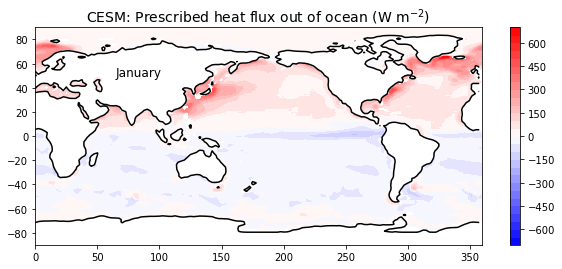

In [10]:
fig4, ax4 = plt.subplots(figsize=(10,4)) 
cax4 = ax4.contourf( som_input.xc, som_input.yc, 
                    -som_input.qdp.isel(time=0), 
                      levels=lev, cmap=plt.cm.bwr)
cbar4 = plt.colorbar(cax4)
ax4.set_title( 'CESM: Prescribed heat flux out of ocean (W m$^{-2}$)', 
              fontsize=14 )
ax3.set_xlabel('Longitude', fontsize=14)
ax3.set_ylabel('Latitude', fontsize=14)
ax4.text(65, 50, 'January', fontsize=12 );
ax4.contour(topo.lon, topo.lat, topo.LANDFRAC, levels=[0.5], colors='k');

### The "Pre-industrial" Control Run

For our pre-industrial climate simulation, we will deviate a bit from Brian Rose's original notebook and use the file named 'b_pi_x2_atm_h0_cat.nc', provided to our class by Dr. Huber.

In [11]:
# Opening and examining the dataset
atm_control = xr.open_dataset("/Users/adamaleksinski/Google Drive/Academics/Courses/EAPS 420 - Climate Modeling/Labs/b_pi_x2_atm_h0_cat.nc")
print(atm_control)

<xarray.Dataset>
Dimensions:          (ilev: 27, lat: 96, lev: 26, lon: 144, nbnd: 2, slat: 95, slon: 144, time: 4)
Coordinates:
  * lev              (lev) float64 3.545 7.389 13.97 23.94 ... 929.6 970.6 992.6
  * ilev             (ilev) float64 2.194 4.895 9.882 ... 956.0 985.1 1e+03
  * time             (time) object 0561-07-01 00:00:00 ... 0562-07-01 00:00:00
  * lat              (lat) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon              (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * slat             (slat) float64 -89.05 -87.16 -85.26 ... 85.26 87.16 89.05
  * slon             (slon) float64 -1.25 1.25 3.75 6.25 ... 351.2 353.8 356.2
Dimensions without coordinates: nbnd
Data variables:
    hyam             (lev) float64 ...
    hybm             (lev) float64 ...
    hyai             (ilev) float64 ...
    hybi             (ilev) float64 ...
    P0               float64 ...
    date             (time) int32 ...
    datesec          (time) int32 ...
  

There are many different variables included in this dataset, including spatial coordinates, time, atmospheric chemistry and ice quantities, energy balance information, and much more. For the purposes of these exercises, however, we are most interested in the mean global insolation. This is contained in the variable 'SOLIN'. Let's take a look at it.

In [12]:
atm_control.SOLIN

<xarray.DataArray 'SOLIN' (time: 4, lat: 96, lon: 144)>
array([[[  0.     ,   0.     , ...,   0.     ,   0.     ],
        [  0.     ,   0.     , ...,   0.     ,   0.     ],
        ...,
        [516.2945 , 516.2947 , ..., 516.29425, 516.2944 ],
        [516.577  , 516.577  , ..., 516.577  , 516.577  ]],

       [[548.506  , 548.506  , ..., 548.506  , 548.506  ],
        [548.20605, 548.2061 , ..., 548.206  , 548.206  ],
        ...,
        [  0.     ,   0.     , ...,   0.     ,   0.     ],
        [  0.     ,   0.     , ...,   0.     ,   0.     ]],

       [[312.25665, 312.25665, ..., 312.25665, 312.25665],
        [312.08597, 312.08566, ..., 312.08655, 312.08624],
        ...,
        [  0.     ,   0.     , ...,   0.     ,   0.     ],
        [  0.     ,   0.     , ...,   0.     ,   0.     ]],

       [[  0.     ,   0.     , ...,   0.     ,   0.     ],
        [  0.     ,   0.     , ...,   0.     ,   0.     ],
        ...,
        [516.2945 , 516.2947 , ..., 516.29425, 516.2944 ],
        [516.577  , 516.577  , ..., 516.577  , 516.577  ]]], dtype=float32)
Coordinates:
  * time     (time) object 0561-07-01 00:00:00 ... 0562-07-01 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Solar insolation
    cell_methods:       time: mean

The 'SOLIN' variable has three different dimensions: time, latitude, and longitude, with data points recorded in units of watts/meter squared. We can work with this data a bit more easily by taking a time average over the variable, effectively removing the time dimension.

In [13]:
timeavg = atm_control.SOLIN.mean(dim='time') # Averaging the dataset across the 'time' dimension
timeavg

<xarray.DataArray 'SOLIN' (lat: 96, lon: 144)>
array([[215.19066, 215.19066, 215.19066, ..., 215.19066, 215.19066,
        215.19066],
       [215.073  , 215.07294, 215.07288, ..., 215.07318, 215.07314,
        215.07306],
       [214.72015, 214.72005, 214.71991, ..., 214.72054, 214.72043,
        214.72029],
       ...,
       [257.72372, 257.72388, 257.724  , ..., 257.72333, 257.72345,
        257.7236 ],
       [258.14725, 258.14734, 258.1474 , ..., 258.14706, 258.14713,
        258.1472 ],
       [258.2885 , 258.2885 , 258.2885 , ..., 258.2885 , 258.2885 ,
        258.2885 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

This array still has a shape of 96 x 144. Although the dimensions aren't the same size, we can plot both of them to a contour plot in order to get a good "map-like" look at where insolation falls onto the Earth's surface. 
- Note: The latitude and longitude tick marks don't map correctly because their labels aren't written from the actual lat/lon values. Hopefully we can learn how to work around this in the future, but struggling with pyplot formatting doesn't seem like a good use of our time right now.

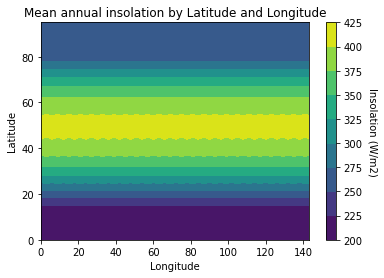

In [40]:
is1 = plt.contourf(timeavg) # Creating a contour plot
plt.xlabel('Longitude') # Labeling axes and the color bar
plt.ylabel('Latitude')
plt.title('Mean annual insolation by Latitude and Longitude')
cbar1 = plt.colorbar(is1)
cbar1.set_label('Insolation (W/m2)', rotation=270, labelpad=15)

If a contour plot would be too confusing, we can further collapse dimensions simply by applying the `.mean()` operation again. This would allow us to make a simple scatter plot through the mean across both time and a spatial dimension. Let's see how it looks when we collapse the dataset to a mean longitude value, and then again by latitude.

Text(0.5, 1.0, 'Mean annual insolation by Latitude')

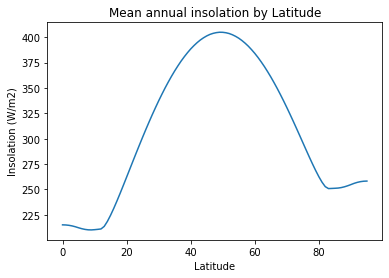

In [15]:
lonavg = timeavg.mean(dim='lon') # Averaging the time-averaged dataset across longitude (Preserving latitude)
plt.plot(lonavg)
plt.xlabel('Latitude')
plt.ylabel('Insolation (W/m2)')
plt.title('Mean annual insolation by Latitude')

Text(0.5, 1.0, 'Mean annual insolation by Longitude')

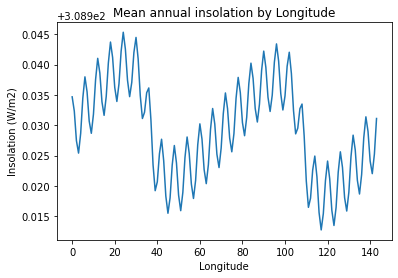

In [16]:
latavg = timeavg.mean(dim='lat') # Averaging the time-averaged dataset across latitude (Preserving longitude)
plt.plot(latavg)
plt.xlabel('Longitude')
plt.ylabel('Insolation (W/m2)')
plt.title('Mean annual insolation by Longitude')

We're now ready to compare our control run to the observed energy budget of the Earth. Up to now, we have been discussing the planet's energy budget in terms of an annual global mean. We can't simply take an average over all latitude and longitude points, however, because our grid cells do not have equal areas. In our particular case, because we are simply treating latitude and longitude as X and Y coordinates, there is very significant area distortion towards the poles. We need a numerical way to compensate for this. Thankfully, we have a few ways to do this.

### Method 1: Calculating area weights mathematically

Because the area of each grid cell is proportional to the cosine of its latitude, we can use that as the weight by which to multiply the area of our cells. This will have the effect of greatly reducing the area of grid cells near the poles, while leaving low-latitude grid cells mostly unaltered.

In [17]:
#  Take the cosine of latitude (first converting to radians)
coslat = np.cos(np.deg2rad(atm_control.lat))
print(coslat)

<xarray.DataArray 'lat' (lat: 96)>
array([6.12323400e-17, 3.30633693e-02, 6.60905843e-02, 9.90455303e-02,
       1.31892171e-01, 1.64594590e-01, 1.97117027e-01, 2.29423920e-01,
       2.61479941e-01, 2.93250037e-01, 3.24699469e-01, 3.55793847e-01,
       3.86499169e-01, 4.16781860e-01, 4.46608807e-01, 4.75947393e-01,
       5.04765538e-01, 5.33031729e-01, 5.60715057e-01, 5.87785252e-01,
       6.14212713e-01, 6.39968541e-01, 6.65024572e-01, 6.89353409e-01,
       7.12928448e-01, 7.35723911e-01, 7.57714870e-01, 7.78877279e-01,
       7.99187997e-01, 8.18624815e-01, 8.37166478e-01, 8.54792713e-01,
       8.71484244e-01, 8.87222819e-01, 9.01991230e-01, 9.15773327e-01,
       9.28554038e-01, 9.40319390e-01, 9.51056516e-01, 9.60753676e-01,
       9.69400266e-01, 9.76986831e-01, 9.83505075e-01, 9.88947871e-01,
       9.93309266e-01, 9.96584493e-01, 9.98769969e-01, 9.99863305e-01,
       9.99863305e-01, 9.98769969e-01, 9.96584493e-01, 9.93309266e-01,
       9.88947871e-01, 9.83505075e-01, 9.7

In [18]:
#  And divide by its mean value
weight_factor = coslat / coslat.mean(dim='lat') 
#  Want to see what we just created?
print(weight_factor)

<xarray.DataArray 'lat' (lat: 96)>
array([9.72048516e-17, 5.24872953e-02, 1.04917196e-01, 1.57232372e-01,
       2.09375617e-01, 2.61289912e-01, 3.12918491e-01, 3.64204898e-01,
       4.15093052e-01, 4.65527308e-01, 5.15452516e-01, 5.64814085e-01,
       6.13558038e-01, 6.61631075e-01, 7.08980627e-01, 7.55554920e-01,
       8.01303024e-01, 8.46174915e-01, 8.90121527e-01, 9.33094803e-01,
       9.75047755e-01, 1.01593451e+00, 1.05571035e+00, 1.09433178e+00,
       1.13175659e+00, 1.16794383e+00, 1.20285394e+00, 1.23644875e+00,
       1.26869152e+00, 1.29954700e+00, 1.32898144e+00, 1.35696266e+00,
       1.38346006e+00, 1.40844466e+00, 1.43188916e+00, 1.45376790e+00,
       1.47405697e+00, 1.49273418e+00, 1.50977911e+00, 1.52517311e+00,
       1.53889936e+00, 1.55094285e+00, 1.56129040e+00, 1.56993071e+00,
       1.57685432e+00, 1.58205366e+00, 1.58552305e+00, 1.58725870e+00,
       1.58725870e+00, 1.58552305e+00, 1.58205366e+00, 1.57685432e+00,
       1.56993071e+00, 1.56129040e+00, 1.5

### Method 2: Using pre-written weights

Thankfully, our dataset also includes the `gw` variable, which includes gaussian weight factors created especially for this purpose. We can do the same thing with these weight factors as we did with the calculated ones.

In [19]:
weight_factor2 = atm_control.gw / atm_control.gw.mean(dim='lat')
weight_factor2

<xarray.DataArray 'gw' (lat: 96)>
array([0.00656136, 0.05248012, 0.10490285, 0.15721088, 0.209347  ,
       0.26125419, 0.31287572, 0.36415511, 0.41503631, 0.46546367,
       0.51538206, 0.56473688, 0.61347417, 0.66154063, 0.70888371,
       0.75545164, 0.80119349, 0.84605925, 0.88999985, 0.93296725,
       0.97491447, 1.01579563, 1.05556604, 1.09418219, 1.13160188,
       1.16778418, 1.20268952, 1.23627974, 1.2685181 , 1.29936936,
       1.32879977, 1.35677717, 1.38327095, 1.40825214, 1.43169343,
       1.45356918, 1.47385547, 1.49253013, 1.50957273, 1.52496463,
       1.538689  , 1.55073084, 1.56107698, 1.56971611, 1.57663877,
       1.5818374 , 1.58530632, 1.58704173, 1.58704173, 1.58530632,
       1.5818374 , 1.57663877, 1.56971611, 1.56107698, 1.55073084,
       1.538689  , 1.52496463, 1.50957273, 1.49253013, 1.47385547,
       1.45356918, 1.43169343, 1.40825214, 1.38327095, 1.35677717,
       1.32879977, 1.29936936, 1.2685181 , 1.23627974, 1.20268952,
       1.16778418, 1.13160188, 1.09418219, 1.05556604, 1.01579563,
       0.97491447, 0.93296725, 0.88999985, 0.84605925, 0.80119349,
       0.75545164, 0.70888371, 0.66154063, 0.61347417, 0.56473688,
       0.51538206, 0.46546367, 0.41503631, 0.36415511, 0.31287572,
       0.26125419, 0.209347  , 0.15721088, 0.10490285, 0.05248012,
       0.00656136])
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0

Let's compare our model's total solar insolation to the known real-world value, 340.3 W m$^{-2}$.

In [20]:
#  Compute the global, time average insolation using our two different weight factors
#  Notice that we can apply the .mean() operation simultaneously over several dimensions!
print( (atm_control.SOLIN * weight_factor).mean(dim=('time', 'lon', 'lat')))
print( (atm_control.SOLIN * weight_factor2).mean(dim=('time', 'lon', 'lat')))

<xarray.DataArray ()>
array(339.89286626)
<xarray.DataArray ()>
array(339.87876572)


They both come quite close. It looks like the calculated area weight actually brings us a bit closer to the known value, but that doesn't necessarily make it better.

### Plotting timeseries

We can use the time dimension found in many of the different data from the dataset in order to construct time series. For this example, we'll be looking at global surface temperatures, found in the dataset's `'TS'` label. Let's take a look at this array.

In [21]:
atm_control.TS

<xarray.DataArray 'TS' (time: 4, lat: 96, lon: 144)>
array([[[220.32353, 220.3635 , ..., 220.33249, 220.33315],
        [219.80498, 219.54314, ..., 220.22212, 219.97174],
        ...,
        [271.77237, 271.79675, ..., 271.7665 , 271.767  ],
        [272.0528 , 272.0589 , ..., 272.04858, 272.04898]],

       [[244.11806, 244.38945, ..., 244.226  , 244.22693],
        [244.13438, 243.96828, ..., 243.64417, 243.60565],
        ...,
        [238.47043, 238.57033, ..., 238.23882, 238.35414],
        [236.5515 , 236.56372, ..., 236.49808, 236.52899]],

       [[232.00798, 232.5703 , ..., 232.23581, 232.2337 ],
        [232.07709, 231.9042 , ..., 231.13571, 230.9355 ],
        ...,
        [234.1323 , 234.07967, ..., 234.21292, 234.17442],
        [233.02655, 233.01096, ..., 233.03325, 233.03227]],

       [[223.89507, 223.93134, ..., 223.90714, 223.90594],
        [222.81847, 222.58911, ..., 223.2433 , 222.98215],
        ...,
        [269.33047, 269.2926 , ..., 269.41617, 269.37738],
        [269.37988, 269.37338, ..., 269.39633, 269.38644]]], dtype=float32)
Coordinates:
  * time     (time) object 0561-07-01 00:00:00 ... 0562-07-01 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    units:         K
    long_name:     Surface temperature (radiative)
    cell_methods:  time: mean

As we can see, the data is presented in units of Kelvins, and it includes a time dimension as well as latitude and longitude. The time dimension only seems to have four points, so the data is very sparse and the time series will look a bit strange. Let's go ahead and apply our latitudinal weights and take the mean across these spatial dimensions, so that we have a nice global average time series.

In [22]:
TSglobal = (atm_control.TS * weight_factor).mean(dim=('lon','lat')) # Averaging the surface temperature dataset
# across both latitude and longitude, preserving only the time variable
TSglobal

<xarray.DataArray (time: 4)>
array([289.32457664, 285.5754482 , 285.93061082, 289.03201476])
Coordinates:
  * time     (time) object 0561-07-01 00:00:00 ... 0562-07-01 00:00:00

Plotting the data gives us this:

Text(0.5, 0, 'Time (Year-Month)')

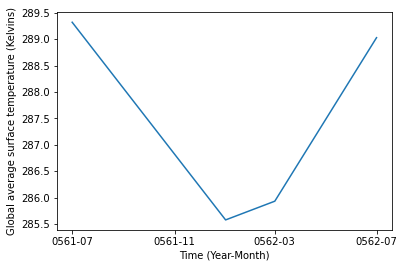

In [23]:
TSglobal.plot()
plt.ylabel('Global average surface temperature (Kelvins)')
plt.xlabel('Time (Year-Month)')

With such a small selection of data, it's hard to make any reasonable observations about its behavior. The only thing that can be inferred with any kind of certainty is the presence of a seasonal cycle -- the planet warms in the summer months, and cools off in the winter months. The data only spans one full year, though, so long-term trends can't be ascertained.

We can use more xarray utilities to analyze this data. For instance, let's find the mean surface temperature. (With only four data points it won't mean much, but just for the sake of demonstrating the code, let's do it anyway.)

In [24]:
TSglobal.mean(dim='time')

<xarray.DataArray ()>
array(287.46566261)

The dataset also includes data pertaining to energy flux, which can also be viewed as time series. They are labeled by an idiosyncratic naming system that explains their contents. The scheme follows these rules:
- `'FL'` means **longwave flux** (i.e. terrestrial)
- `'FS'` means **shortwave flux** (i.e. solar)
- The third letter indicates **direction** of the flux:
    - `'U'` = up
    - `'D'` = down
    - `'N'` = net
- The fourth letter indicates the **location** of the flux:
    - `'T'` = top of atmosphere
    - `'S'` = surface

For example, the `'FLNT'` label contains data on the net longwave raditation flux at the top of the atmosphere. What does this dataset look like?

In [25]:
atm_control.FLNT

<xarray.DataArray 'FLNT' (time: 4, lat: 96, lon: 144)>
array([[[113.94094 , 113.972755, ..., 113.94211 , 113.94308 ],
        [111.67516 , 112.054504, ..., 112.94084 , 112.88711 ],
        ...,
        [226.65594 , 226.8129  , ..., 226.46506 , 226.51567 ],
        [227.63042 , 227.62587 , ..., 227.63475 , 227.63402 ]],

       [[173.29813 , 173.6173  , ..., 173.41891 , 173.41972 ],
        [170.92586 , 170.90005 , ..., 170.10982 , 170.18163 ],
        ...,
        [155.33336 , 155.53906 , ..., 154.96121 , 155.219   ],
        [152.2849  , 152.27873 , ..., 152.24893 , 152.27469 ]],

       [[158.98518 , 159.73009 , ..., 159.28227 , 159.27962 ],
        [158.21802 , 157.87218 , ..., 157.12569 , 156.75536 ],
        ...,
        [140.05864 , 140.51558 , ..., 139.42195 , 139.55254 ],
        [139.5125  , 139.48065 , ..., 139.53932 , 139.53065 ]],

       [[104.67937 , 104.69685 , ..., 104.67659 , 104.6749  ],
        [104.4071  , 103.583015, ..., 103.29469 , 103.43161 ],
        ...,
        [222.96669 , 223.17456 , ..., 222.53201 , 222.71527 ],
        [224.8093  , 224.79327 , ..., 224.83185 , 224.81918 ]]], dtype=float32)
Coordinates:
  * time     (time) object 0561-07-01 00:00:00 ... 0562-07-01 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Net longwave flux at top of model
    cell_methods:       time: mean

So with all that in mind, let's take a few moments to analyze the time series of insolation (SOLIN), absorbed solar radiation (FSNS), and outgoing longwave radiation (FLNT).

Text(0.5, 0, 'Time (Year-Month)')

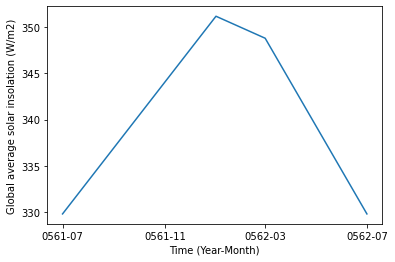

In [26]:
# Insolation time series
SOLINglobal = (atm_control.SOLIN * weight_factor).mean(dim=('lon','lat'))
SOLINglobal.plot()
plt.ylabel('Global average solar insolation (W/m2)')
plt.xlabel('Time (Year-Month)')

Text(0.5, 0, 'Time (Year-Month)')

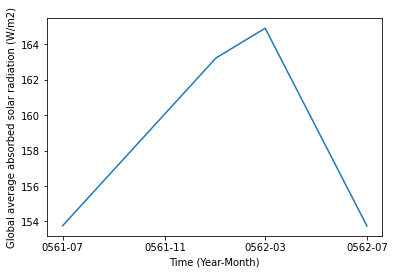

In [27]:
# ASR time series
FSNSglobal = (atm_control.FSNS * weight_factor).mean(dim=('lon','lat'))
FSNSglobal.plot()
plt.ylabel('Global average absorbed solar radiation (W/m2)')
plt.xlabel('Time (Year-Month)')

Text(0.5, 0, 'Time (Year-Month)')

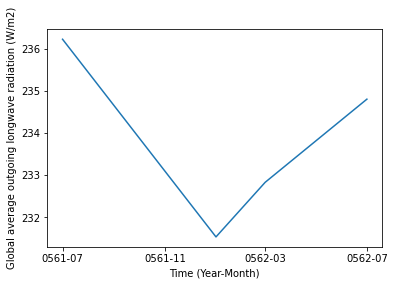

In [28]:
# OLR time series
FLNTglobal = (atm_control.FLNT * weight_factor).mean(dim=('lon','lat'))
FLNTglobal.plot()
plt.ylabel('Global average outgoing longwave radiation (W/m2)')
plt.xlabel('Time (Year-Month)')

There's one more variable for us to look at, and that's planetary albedo. The dataset doesn't include this, but since albedo is the ratio of outgoing to incoming solar radiation, it shouldn't be hard to determine this for ourselves.

In [29]:
# Albedo data array
FSUTOAglobal = (atm_control.FSUTOA * weight_factor).mean(dim=('lon','lat')) # Utilizing the upward (outgoing) solar 
# radiation flux at the top of the atmosphere
FSDTOAglobal = (atm_control.FSDTOA * weight_factor).mean(dim=('lon','lat')) # Utilizing the downward (incoming) solar
# radiation flux at the top of the atmosphere
ALBglobal = FSUTOAglobal/FSDTOAglobal
ALBglobal

<xarray.DataArray (time: 4)>
array([0.30460381, 0.3158565 , 0.30653701, 0.30501064])
Coordinates:
  * time     (time) object 0561-07-01 00:00:00 ... 0562-07-01 00:00:00

The numbers seem to check out, so let's plot this up.

Text(0.5, 0, 'Time (Year-Month)')

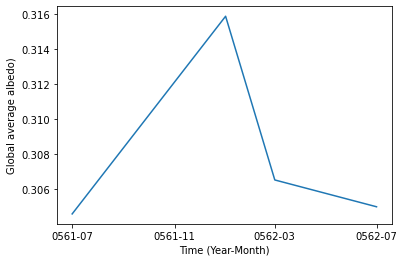

In [30]:
# Albedo time series
ALBglobal.plot()
plt.ylabel('Global average albedo)')
plt.xlabel('Time (Year-Month)')

Some things to comment on:
- Insolation and ASR reach their peak in the winter/spring months, and bottom out in the summer.
- OLR has the opposite trend, reaching its maximum in the summer and its minimum in the winter.
- Albedo follows a similar pattern to insolation and ASR, but with a sharper peak in the middle of the winter. One could guess that this has to do with snow and ice covering much of the northern hemisphere at that time.
- Once again, in case this wasn't made abundantly clear, it's difficult to say much of anything valuable based on a time series of four data points.

### Playing with the data some more

The lab finishes with a few more looks at the data. For instance, it points out that many of the data variables have a fourth dimension:

In [31]:
atm_control.T

<xarray.DataArray 'T' (time: 4, lev: 26, lat: 96, lon: 144)>
[1437696 values with dtype=float32]
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
  * time     (time) object 0561-07-01 00:00:00 ... 0562-07-01 00:00:00
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    mdims:         1
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean

Here, the air temperature has a dimension called "level", representing an altitude in the atmosphere. 

What if we want to examine the data over a particular area, or for a different time of the yar? We can use xarray's .interp method to interpolate data at whatever parameter we specify. For instance, this example creates an interpolated dataset of air temperature at the position of Albany, New York:

In [32]:
Tlocal = atm_control.T.interp(lat=42.75, lon=(360-73.8)) # Interpolating at those specific latitude and longitude
# coordinates
Tlocal

<xarray.DataArray 'T' (time: 4, lev: 26)>
array([[247.00397541, 238.45962963, 231.90161232, 227.30379913,
        224.46083752, 218.94479538, 214.65878269, 211.69737186,
        211.19561161, 210.33369244, 208.55361542, 208.06390079,
        211.11697624, 217.76522545, 225.81927238, 234.67661694,
        243.76436172, 251.69659119, 259.82170746, 267.79636459,
        274.21691284, 279.32954514, 284.7375705 , 289.30906219,
        291.96973534, 292.02109978],
       [220.89625881, 219.27250198, 219.52798111, 218.92517067,
        218.00531174, 216.64564903, 214.42553455, 211.35666382,
        210.29980305, 209.73472271, 209.23019886, 209.51044922,
        211.3351614 , 215.89914997, 222.38332142, 230.08255417,
        238.43489803, 246.5883707 , 254.64711395, 261.9178141 ,
        268.31268318, 271.77304649, 274.35459579, 274.43009727,
        275.1660511 , 275.44978554],
       [226.26058659, 219.36119438, 215.78134613, 215.529058  ,
        215.44734356, 214.5845657 , 214.34906647, 214.03685345,
        214.94489719, 216.33533939, 217.06796196, 217.58476181,
        216.43110283, 216.15478664, 218.7215044 , 223.95981441,
        230.97299221, 238.98663601, 246.98430912, 254.3430024 ,
        260.06241714, 264.15077065, 266.41308289, 266.71174835,
        268.30619225, 269.08241379],
       [246.86430885, 238.29288746, 231.78836269, 226.91873142,
        223.83689293, 219.91395527, 216.09952221, 213.48049786,
        213.22830639, 212.80208664, 211.3785656 , 210.66801044,
        212.22709122, 217.51333797, 225.03384731, 233.42675278,
        242.14669449, 250.55550842, 258.72814255, 266.50764153,
        273.32044144, 279.44349358, 286.10229027, 291.18221756,
        293.81011902, 293.51022049]])
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
  * time     (time) object 0561-07-01 00:00:00 ... 0562-07-01 00:00:00
    lat      float64 42.75
    lon      float64 286.2
Attributes:
    mdims:         1
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean

We can also index the array to pick out particular data points. Here, we index the data by time to pick out the very first month in the collection. (The .sel method uses a year-month syntax, and the model run apparently begins in the year 561 in the month of July.)

In [33]:
Tlocal.time
Tlocal.sel(time='0561-07')

<xarray.DataArray 'T' (time: 1, lev: 26)>
array([[247.00397541, 238.45962963, 231.90161232, 227.30379913,
        224.46083752, 218.94479538, 214.65878269, 211.69737186,
        211.19561161, 210.33369244, 208.55361542, 208.06390079,
        211.11697624, 217.76522545, 225.81927238, 234.67661694,
        243.76436172, 251.69659119, 259.82170746, 267.79636459,
        274.21691284, 279.32954514, 284.7375705 , 289.30906219,
        291.96973534, 292.02109978]])
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6
  * time     (time) object 0561-07-01 00:00:00
    lat      float64 42.75
    lon      float64 286.2
Attributes:
    mdims:         1
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean

What does this particular indexed slice look like visually?

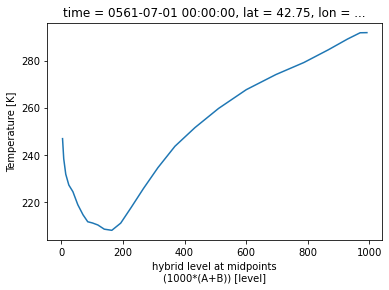

In [34]:
Tlocal.sel(time='0561-07').plot()

As we can see, this produces a plot of temperature versus atmospheric level. You can put your finger on the spot where the temperature inverts at the tropopause -- a testiment to the level of detail in the model.

### Concluding remarks

This was an interesting lab assignment that taught us how to use CESM data in a very thorough and analytical way. The experience was soured a little bit by the fact that the original datasets are no longer accessible, as well as some of the challenges involved in learning to use xarray and all its dependent libraries. Even so, this was a good learning experience, and it will certainly help us more easily diagnose common problems when we work more closely with CESM later on.